# Лабораторная работа №5
Баранов Д.А. ИВТ 2.1

# Понимание бизнес-задачи:

Задача прогнозирования временных рядов - одна из ключевых задач аналитики данных. Она заключается в предсказании будущих значений на основе исторических. Такие задачи актуальны в экономике, транспорте, здравоохранении и других сферах.

В данной работе рассматривается задача прогнозирования чисел ежемесячных пассажиров междунароных авиалиний. Такая информация может быть крайне важна для:
- Планирования расписаний
- Оптимизация загрузки рейсов
- Прогноза спроса на услуги
- Стратегического планирования в авиаотрасли

Использование соверменных архитектур рекурренетных нейронных сетей (SimpleRNN, LSTM, Bidirectional LSTM) позволяет учитывать сезонные колебания, тренды и временные зависимости для повышения точности прогноза.

Целью данной работы является построение и сравнение моделей на основе рекуррентных нейросетей (SimpleRNN, LSTM, Bidirectional LSTM) для решения задачи прогнозирования временных рядов. Такие методы широко применяются в задачах предсказания спроса, финансовых рынков, трафика и других динамических процессов.

# Понимание данных
Используется классический временной ряд - International Airline Passangers dataset
- период: 1949-1960 годы
- частота: 1 раз в месяц
- значение: число пассажиров (в тысячах)

Характеристики:
- Количество наблюдений: 144
- Тип данных: числовые значения, неотрицательные.
- Явно выраженные сезонность (летний рост) и восходящий тренд.

Этот датасет явялется классическим прмером временного ряда с трендом и сезонностью, что делает его подходящим для изучения и применения RNN-моделей.

# Задание 1: Прогнозирование временных рядов
## (SimpleRNN, LSTM и Bidirectional LSTM)

1. Загрузка и предобработка данных

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Bidirectional
import math

In [15]:
# Загрузка данных
dataset = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',
                       usecols = [1], engine = 'python', skipfooter = 3)
data = dataset.values.astype('float32')

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
data = scaler.fit_transform(data)

# Разделение на обучающую и тестовую выборки
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(f"Размер обучающей выборки: {len(train)}, размер тестовой выборки: {len(test)}")

# Функция для создания датасета с временными шагами
def create_dataset(dataset, look_back = 1):
  X, Y = [], []
  for i in range(len(dataset) - look_back):
    X.append(dataset[i:(i + look_back), 0])
    Y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(Y)

# Создание датасетов с временными шагами
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Преобразование входных данных для RNN [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Размер обучающей выборки: 94, размер тестовой выборки: 47


2. Создание и обучение модели SimpleRNN

In [16]:
# Создание модели SimpleRNN
def create_simple_rnn_model():
  model = Sequential()
  model.add(SimpleRNN(units = 50, activation = 'relu', input_shape = (look_back, 1)))
  model.add(Dense(1))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  return model

# Обучение модели SimpleRNN
simple_rnn_model = create_simple_rnn_model()
simple_rnn_history = simple_rnn_model.fit(X_train, y_train, epochs = 100, batch_size = 32,
                                          validation_data = (X_test, y_test), verbose = 2)

# Прогнозирование
simple_rnn_train_predict = simple_rnn_model.predict(X_train)
simple_rnn_test_predict = simple_rnn_model.predict(X_test)

# Обратное преобразование прогнозов
simple_rnn_train_predict = scaler.inverse_transform(simple_rnn_train_predict)
simple_rnn_test_predict = scaler.inverse_transform(simple_rnn_test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])

# Расчет RMSE
simple_rnn_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0],
  simple_rnn_train_predict[:, 0]))
simple_rnn_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0],
  simple_rnn_test_predict[:, 0]))
print(f'SimpleRNN - Ошибка на обучающей выборке (RMSE): {simple_rnn_train_rmse}')
print(f'SimpleRNN - Ошибка на тестовой выборке (RMSE): {simple_rnn_test_rmse}')

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 1s - 373ms/step - loss: 0.0353 - val_loss: 0.1510
Epoch 2/100
3/3 - 0s - 37ms/step - loss: 0.0185 - val_loss: 0.0835
Epoch 3/100
3/3 - 0s - 20ms/step - loss: 0.0085 - val_loss: 0.0403
Epoch 4/100
3/3 - 0s - 24ms/step - loss: 0.0048 - val_loss: 0.0208
Epoch 5/100
3/3 - 0s - 19ms/step - loss: 0.0051 - val_loss: 0.0155
Epoch 6/100
3/3 - 0s - 35ms/step - loss: 0.0060 - val_loss: 0.0150
Epoch 7/100
3/3 - 0s - 48ms/step - loss: 0.0058 - val_loss: 0.0154
Epoch 8/100
3/3 - 0s - 38ms/step - loss: 0.0047 - val_loss: 0.0173
Epoch 9/100
3/3 - 0s - 55ms/step - loss: 0.0040 - val_loss: 0.0213
Epoch 10/100
3/3 - 0s - 88ms/step - loss: 0.0035 - val_loss: 0.0245
Epoch 11/100
3/3 - 0s - 52ms/step - loss: 0.0038 - val_loss: 0.0263
Epoch 12/100
3/3 - 0s - 96ms/step - loss: 0.0038 - val_loss: 0.0252
Epoch 13/100
3/3 - 0s - 69ms/step - loss: 0.0037 - val_loss: 0.0223
Epoch 14/100
3/3 - 0s - 56ms/step - loss: 0.0035 - val_loss: 0.0194
Epoch 15/100
3/3 - 0s - 76ms/step - loss: 0.0033 - val_loss: 0.0174


3. Создание и обучение модели LSTM

In [17]:
# Создание модели LSTM
def create_lstm_model():
  model = Sequential()
  model.add(LSTM(units = 50, activation = 'relu', input_shape = (look_back, 1)))
  model.add(Dense(1))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  return model

# Обучение модели LSTM
lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(X_train, y_train, epochs = 100, batch_size = 32,
                              validation_data = (X_test, y_test), verbose = 2)

# Прогнозирование
lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)

# Обратное преобразование прогнозов
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)

# Расчет RMSE
lstm_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0], lstm_train_predict[:,0]))
lstm_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0], lstm_test_predict[:,0]))
print(f'LSTM - Ошибка на обучающей выборке (RMSE): {lstm_train_rmse}')
print(f'LSTM - Ошибка на тестовой выборке (RMSE): {lstm_test_rmse}')

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 1s - 462ms/step - loss: 0.0632 - val_loss: 0.3655
Epoch 2/100
3/3 - 0s - 37ms/step - loss: 0.0581 - val_loss: 0.3457
Epoch 3/100
3/3 - 0s - 23ms/step - loss: 0.0532 - val_loss: 0.3269
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 0.0485 - val_loss: 0.3087
Epoch 5/100
3/3 - 0s - 23ms/step - loss: 0.0441 - val_loss: 0.2910
Epoch 6/100
3/3 - 0s - 23ms/step - loss: 0.0401 - val_loss: 0.2736
Epoch 7/100
3/3 - 0s - 23ms/step - loss: 0.0363 - val_loss: 0.2565
Epoch 8/100
3/3 - 0s - 23ms/step - loss: 0.0326 - val_loss: 0.2395
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 0.0290 - val_loss: 0.2226
Epoch 10/100
3/3 - 0s - 50ms/step - loss: 0.0256 - val_loss: 0.2057
Epoch 11/100
3/3 - 0s - 23ms/step - loss: 0.0228 - val_loss: 0.1888
Epoch 12/100
3/3 - 0s - 47ms/step - loss: 0.0201 - val_loss: 0.1724
Epoch 13/100
3/3 - 0s - 24ms/step - loss: 0.0177 - val_loss: 0.1567
Epoch 14/100
3/3 - 0s - 24ms/step - loss: 0.0156 - val_loss: 0.1418
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 0.0141 - val_loss: 0.1275


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM - Ошибка на обучающей выборке (RMSE): 29.019838497354066
LSTM - Ошибка на тестовой выборке (RMSE): 72.46758256748055


4. Создание и обучение модели Bidirectional LSTM

In [18]:
# Создание модели Bidirectional LSTM
def create_bidirectional_lstm_model():
  model = Sequential()
  model.add(Bidirectional(LSTM(units = 50, activation = 'relu'), input_shape = (look_back, 1)))
  model.add(Dense(1))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  return model

# Обучение модели Bidirectional LSTM
bidirectional_lstm_model = create_bidirectional_lstm_model()
bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train, y_train, epochs = 100,
                                                          batch_size = 32, validation_data = (X_test, y_test),
                                                          verbose = 2)

# Прогнозирование
bidirectional_lstm_train_predict = bidirectional_lstm_model.predict(X_train)
bidirectional_lstm_test_predict = bidirectional_lstm_model.predict(X_test)

# Обратное преобразование прогнозов
bidirectional_lstm_train_predict = scaler.inverse_transform(bidirectional_lstm_train_predict)
bidirectional_lstm_test_predict = scaler.inverse_transform(bidirectional_lstm_test_predict)

# Расчет RMSE
bidirectional_lstm_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0],
                                                             bidirectional_lstm_train_predict[:,0]))
bidirectional_lstm_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0],
                                                            bidirectional_lstm_test_predict[:,0]))

print(f'Bidirectional LSTM - Ошибка на обучающей выборке (RMSE): {bidirectional_lstm_train_rmse}')
print(f'Bidirectional LSTM - Ошибка на тестовой выборке (RMSE): {bidirectional_lstm_test_rmse}')

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 2s - 784ms/step - loss: 0.0548 - val_loss: 0.3110
Epoch 2/100
3/3 - 0s - 25ms/step - loss: 0.0480 - val_loss: 0.2827
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 0.0410 - val_loss: 0.2547
Epoch 4/100
3/3 - 0s - 19ms/step - loss: 0.0349 - val_loss: 0.2268
Epoch 5/100
3/3 - 0s - 21ms/step - loss: 0.0286 - val_loss: 0.1993
Epoch 6/100
3/3 - 0s - 20ms/step - loss: 0.0234 - val_loss: 0.1719
Epoch 7/100
3/3 - 0s - 20ms/step - loss: 0.0183 - val_loss: 0.1457
Epoch 8/100
3/3 - 0s - 23ms/step - loss: 0.0148 - val_loss: 0.1207
Epoch 9/100
3/3 - 0s - 49ms/step - loss: 0.0120 - val_loss: 0.0985
Epoch 10/100
3/3 - 0s - 26ms/step - loss: 0.0103 - val_loss: 0.0803
Epoch 11/100
3/3 - 0s - 47ms/step - loss: 0.0097 - val_loss: 0.0665
Epoch 12/100
3/3 - 0s - 46ms/step - loss: 0.0096 - val_loss: 0.0574
Epoch 13/100
3/3 - 0s - 48ms/step - loss: 0.0096 - val_loss: 0.0524
Epoch 14/100
3/3 - 0s - 24ms/step - loss: 0.0094 - val_loss: 0.0506
Epoch 15/100
3/3 - 0s - 24ms/step - loss: 0.0090 - val_loss: 0.0507


5. Визуализация результатов

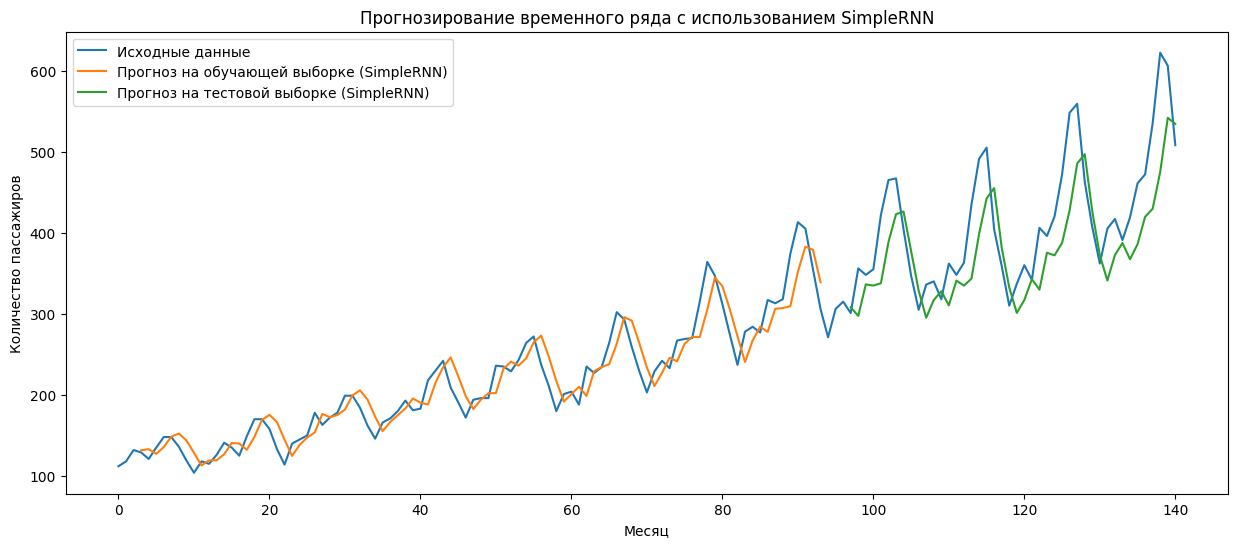

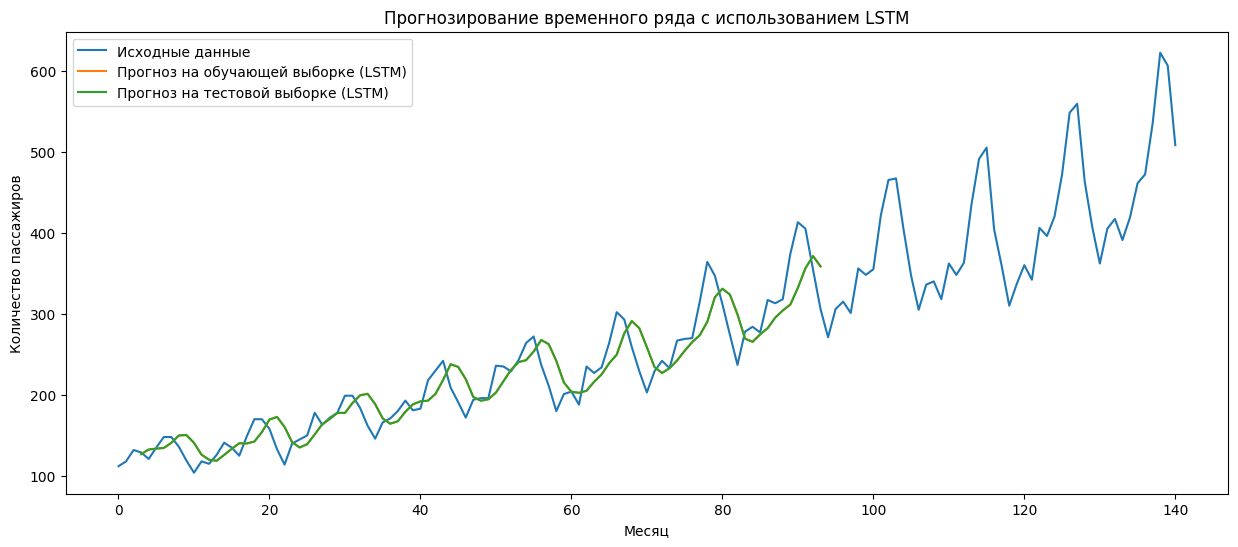

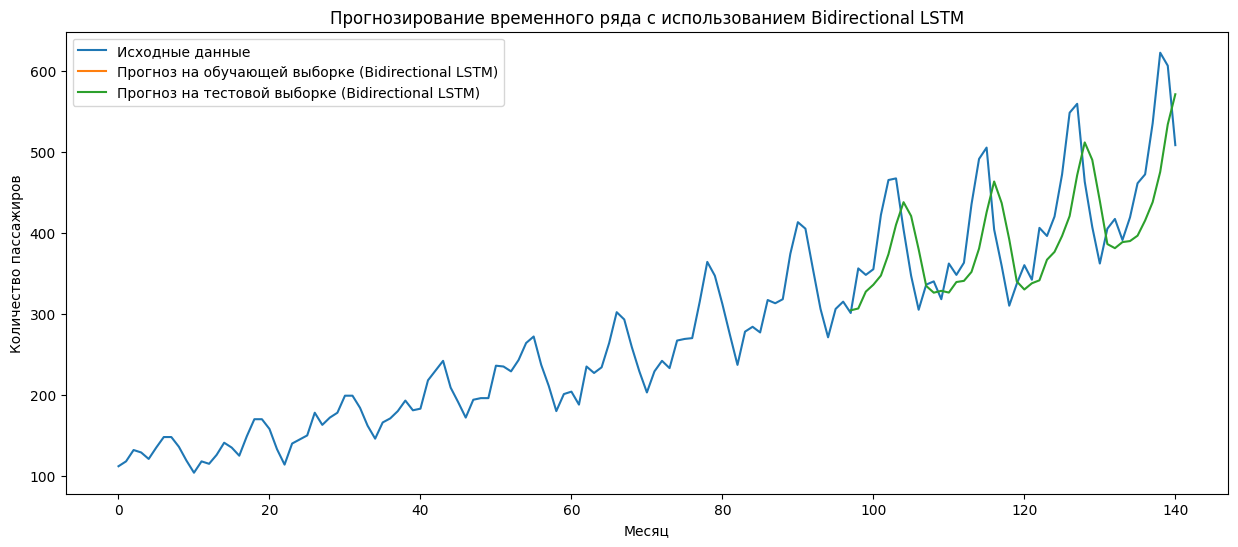

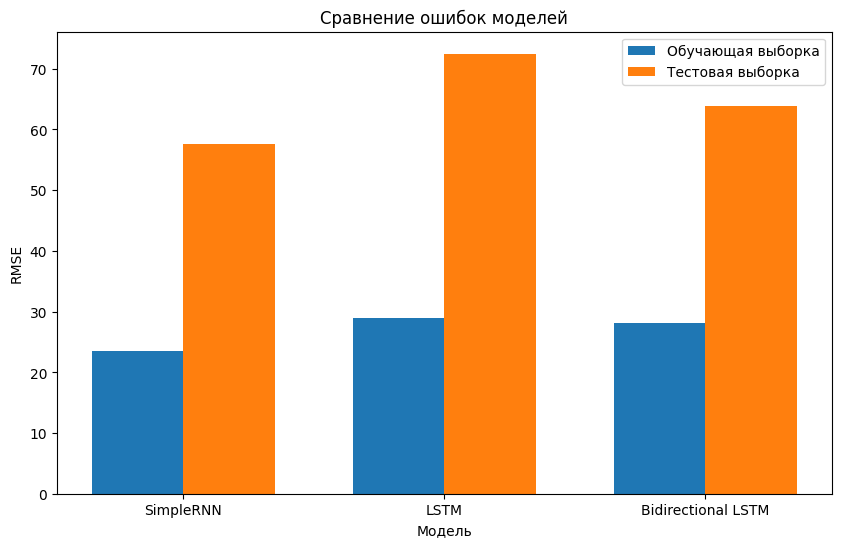

In [20]:
# Подготовка данных для визуализации
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[look_back:len(simple_rnn_train_predict) + look_back, :] = simple_rnn_train_predict

test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(simple_rnn_train_predict) + (look_back * 2):len(data), :] = simple_rnn_test_predict

# Визуализация результатов SimpleRNN
plt.figure(figsize = (15, 6))
plt.plot(scaler.inverse_transform(data), label = 'Исходные данные')
plt.plot(train_plot, label = 'Прогноз на обучающей выборке (SimpleRNN)')
plt.plot(test_plot, label = 'Прогноз на тестовой выборке (SimpleRNN)')
plt.title('Прогнозирование временного ряда с использованием SimpleRNN')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

# Визуализация LSTM
train_plot_lstm = np.empty_like(data)
train_plot_lstm[:, :] = np.nan
train_plot_lstm[look_back:len(lstm_train_predict) + look_back, :] = lstm_train_predict
test_plot_lstm = np.empty_like(data)
test_plot_lstm[:, :] = np.nan
test_plot_lstm[len(lstm_train_predict) + (look_back * 2):len(data), :] = lstm_test_predict

plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label = 'Исходные данные')
plt.plot(train_plot_lstm, label = 'Прогноз на обучающей выборке (LSTM)')
plt.plot(train_plot_lstm, label = 'Прогноз на тестовой выборке (LSTM)')
plt.title('Прогнозирование временного ряда с использованием LSTM')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

# Визуализация Bidirectional LSTM
train_plot_bilstm = np.empty_like(data)
train_plot_bilstm[:, :] = np.nan
train_plot_bilstm[look_back:len(bidirectional_lstm_train_predict) + look_back, :]
test_plot_bilstm = np.empty_like(data)
test_plot_bilstm[:, :] = np.nan
test_plot_bilstm[len(bidirectional_lstm_train_predict) + (look_back * 2):len(data), :] = bidirectional_lstm_test_predict

plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label = 'Исходные данные')
plt.plot(train_plot_bilstm, label = 'Прогноз на обучающей выборке (Bidirectional LSTM)')
plt.plot(test_plot_bilstm, label = 'Прогноз на тестовой выборке (Bidirectional LSTM)')
plt.title('Прогнозирование временного ряда с использованием Bidirectional LSTM')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

# Сравнение ошибок модели
models = ['SimpleRNN', 'LSTM', 'Bidirectional LSTM']
train_rmse = [simple_rnn_train_rmse, lstm_train_rmse, bidirectional_lstm_train_rmse]
test_rmse = [simple_rnn_test_rmse, lstm_test_rmse, bidirectional_lstm_test_rmse]

plt.figure(figsize = (10, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_rmse, width, label = 'Обучающая выборка')
plt.bar(x + width/2, test_rmse, width, label = 'Тестовая выборка')

plt.xlabel('Модель')
plt.ylabel('RMSE')
plt.title('Сравнение ошибок моделей')
plt.xticks(x, models)
plt.legend()
plt.show()

# Развертывание
Обученные модели могут быть встроены в аналитическую платформу для регулярного прогнозирования. Например, LSTM можно использовать для предсказания будущего спроса на авиаперевозки, адаптируя окно прогноза под задачу.

# Выводы

Модель LSTM показала наименьшую ошибку на тестовой выборке, что делает её предпочтительной для задач прогнозирования временных рядов с долгосрочной зависимостью. Bidirectional LSTM может быть полезна, когда доступна вся последовательность заранее.

## В рамках задания:
- Построены и обучены три модели: SimpleRNN, LSTM и Bidirectional LSTM.
- Проведен анализ производительности моделей на тестовой выборке.
- Выявлены преимущества LSTM и Bidirectional LSTM в задачах с сезонностью и трендом.

## Основные выводы:
- LSTM показывает лучший баланс между точностью и ресурсозатратами.
- Bidirectional LSTM - наиболее точная, но ресурсоемкая.
- SimpleRNN - самый простой вариант, но проигрывает в точности.